# Lab 2 - Task 1 Vehicles with over 100K Kilometers/Task 2 Body Type.
IN this lab we will be using a dataset found on Kaggle.com about vehcile advertisements in the Czech republic and Germany.  For task 1 we will be focusing on predicting if a vehicle has over 100K kilometers. For task 2 we will be focusing on predicting the different body types of the vehicles.

    Scott Gozdzialski
    Adam Baca
    Zoheb Allam
    Ethan Graham
    
    The data can be found https://www.kaggle.com/mirosval/personal-cars-classifieds

##  Data Preparation Part 1 

There are roughly 3.5 Million rows and the following columns:

- maker - The manufacturer of the vehicle
- model - The distinct model of the vehicle
- mileage - in KM (our Response variable)
- manufacture_year
- engine_displacement - in cc
- engine_power - in kW
- body_type - Coupe, van, sedan, etc.
- color_slug - main color of the vehicle
- stk_year - year of the last emission control
- transmission - automatic or manual
- door_count
- seat_count
- fuel_type - gasoline, diesel, cng, lpg, electric
- date_created - when the ad was scraped
- date_last_seen - when the ad was last seen. Our policy was to remove all ads older than 60 days
- price_eur - list price converted to EUR

The first step is to download the data.

In [233]:
#Import the file of 3.5 Million records we will parse it down to 81000 usable records
import pandas as pd
import numpy as np
from __future__ import print_function
path = "~\\Desktop\\Cars.csv"

df = pd.read_csv(path,sep = ",")

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7,8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


First we are going to have to clean the data.  As can be seen below most of the data is object type wich will not work for our classification models.

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 16 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
dtypes: float64(5), object(11)
memory usage: 433.7+ MB


First, we change the date the ad was created and the date it was removed to a interger of the number of days the ad ran. then we drop the columns we will not be using. Stk-year is very close to model year, model takes up to much memory seperate and is unworkable.  Finally we will drop all the rows with NAs.  With 3.5 rows we have plenty to use after removing them.

In [235]:
#Convert the date varibles into a delta between and type int
df.date_created = pd.to_datetime(df['date_created'])
df.date_last_seen = pd.to_datetime(df['date_last_seen'])
df['total_days'] = df['date_last_seen'] - df['date_created']
df.total_days = df['total_days'].dt.days.astype(int)

df.drop(['stk_year','model','date_created','date_last_seen'], axis=1, inplace=True)

df = df.dropna()

Next, we convert door count and seat count to ints, and remove eronious information.  There are no vehicles with a 10cc engine.

In [236]:
df.door_count = df.door_count.replace('None','0')
df.door_count = df.door_count.astype(int)
df.seat_count = df.door_count.replace('None','0')
df.seat_count = df.door_count.astype(int)

df = df.sort_values('engine_displacement', ascending=False)
df = df[:82088]

df = df.sort_values('engine_power', ascending=False)
df = df[:81500]

#### Task 1
This is where the dataframe for task one and task two deviate from each other.  Task one will one hot encode body type to predict milage.

Then, we OneHotEncode maker, body type,color slug, and fuel type. We turn Transmision to binary (1,0) variable. Finally we remove the columns that we OneHotEncoded.  We also make a back up dataframe incase we make a mistake we can go backto this point without rerunning everything above.

In [237]:
df2 = df

tmp_df = pd.get_dummies(df.maker,prefix='Maker')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.body_type,prefix='Body type')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.color_slug,prefix='Color')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.fuel_type,prefix='Fuel')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

df['manual'] = df.transmission=='man' 
df.manual = df.manual.astype(np.int)

df.drop(['body_type','color_slug','fuel_type','maker','transmission'], axis= 1, inplace = True)

In [238]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81500 entries, 3215366 to 3153910
Data columns (total 83 columns):
mileage                   81500 non-null float64
manufacture_year          81500 non-null float64
engine_displacement       81500 non-null float64
engine_power              81500 non-null float64
door_count                81500 non-null int32
seat_count                81500 non-null int32
price_eur                 81500 non-null float64
total_days                81500 non-null int32
Maker_alfa-romeo          81500 non-null uint8
Maker_aston-martin        81500 non-null uint8
Maker_audi                81500 non-null uint8
Maker_bentley             81500 non-null uint8
Maker_bmw                 81500 non-null uint8
Maker_chevrolet           81500 non-null uint8
Maker_chrysler            81500 non-null uint8
Maker_citroen             81500 non-null uint8
Maker_dacia               81500 non-null uint8
Maker_dodge               81500 non-null uint8
Maker_fiat                8

Changing mileage to a binary of milage over 100K Kilometers.

In [239]:
df['mileage_100K'] = df['mileage'] > 100000

# we want to predict the X and y data as follows:

y = df['mileage_100K'].values # get the labels we want
del df['mileage_100K'] 
del df['mileage']# get rid of the class label
X = df.values # use everything else to predict!

####  Task 2
For task 2 we will be predicting the body type and leaving mileage as a consistant number.

In [240]:
tmp_df = pd.get_dummies(df2.maker,prefix='Maker')
df2 = pd.concat((df2,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df2.color_slug,prefix='Color')
df2 = pd.concat((df2,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df2.fuel_type,prefix='Fuel')
df2 = pd.concat((df2,tmp_df),axis=1) # add back into the dataframe

df2['manual'] = df2.transmission=='man' 
df2.manual = df2.manual.astype(np.int)

df2.drop(['color_slug','fuel_type','maker','transmission'], axis= 1, inplace = True)
    

In [241]:
y2 = df2['body_type'].values # get the labels we want
del df2['body_type'] 
X2 = df2.values

## Data Preparation part 2 - Final dataset.
The final dataset constists of 81500 records with 82 columns.

First we downloaded our dataset of car sales in the Czech Republic and Germany.  Most of it downloads as obect type so we changed door count and seat count to intergers.  

We calculated the difference between when the advertisment started and was dropped and created a new variable of total days the ad ran.    

We dropped the stk-year and model, stk-year is not needed since it is very similar to model year.  Model has to many classifications in the rows for us to be able to seperate it out.  When we tried we ran out of memory.

#### Task 1

Speaking of seperation the classifactions out, we spereated out Maker, Body type, Color, and Fuel type with one hot endoing. 

#### Task 2

For the seperations in task 2, we seperated out Maker, Color, and Fuel Type with one hot encoding.  We left body type in the dataframe because this will now be our response variable.  Body type has 9 different classifaction we will be focusing on predicting.

#### Both tasks
We also, dropped any row with a NA value.  This was done for two reasons, first it removed useless rows that will mess with our classifiaction models, second since we started with 3.5M records dropping the rows with NAs left us with 81500 rows of usable data.  The entire 3.5M records would eat up the resources of our machines and 81500 records should be a large enough sampleset to properly capture the nature of the data.

## Model and Evaluation 1 - Evaluation Metric.

To evaluate our different classification methods, we will be examining the accuracy with which they can predict vehicles with over 100k miles (task 1) and vehicle body type (task 2). The accuracy of each method will tell us the percentage of our sample correctly classified (PCC), in otherwords the percent of true positives and true negatives. PCC is the most commonly used metric to assess overall model accuracy and is calculated without taking into account what kind of errors are made, meaning each error has the same weight. Since our models aim to predict features in cars and not something related to health care like cancer, we are not concerned about the different impacts the false positives and false negatives may have on our sample and therefore can be treated equally.        

## Model and Evaluation 2 - dividing data

We will be using 10 fold cross validation in order to divide our data into training and testing splits. Cross validation is when you divide a sample of data into subsets and then perform the analysis on a training subset and validate those results with the testing subset. Cross validation allows you to determine if the results of the model will generalize to an independent dataset and also can limit issues like overfitting. 

With 10 fold cross validation, the cross validation process is repeated 10 times with each of the subsamples being used only once for validation. The main advantages to repeating this process 10 times is that all observations are used for both training and validation and therefore we do not lose sample size which can affect modeling capabilities. 

In order to aggregate the results from the 10 fold cross validation we will take the PCC for each model and average it together to form an overall accuracy measure. This will enable us to get a more accurate estimate of each models performance.  

In [225]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)

## Model and Evaluation 3 - Model selection

This is the section where we run different models and evaluate the results.  Each model will be run more than once with different settings.  

For task 1 (mileage) we will  run a random forest, a k nearest neighbors, and a logistic regression. 

For task 2  (body type) we will run a random forest, a k nearest neightbors, and adaboost ensemble.

When we are done.  We will place the models that run the best of each type, for a total of 6, together for further analysis.

In [215]:
from sklearn import model_selection
from sklearn import metrics as mt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Random Forest - task 1 (mileage)

Starting with a randdom forest with 50 classifers as a baseline

In [22]:
clf = RandomForestClassifier(n_estimators=50,random_state=1)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.428045638572
Random Forest  1  accuracy 0.855109802478
Random Forest  2  accuracy 0.87314439946
Random Forest  3  accuracy 0.84713532082
Random Forest  4  accuracy 0.847116564417
Random Forest  5  accuracy 0.794601226994
Random Forest  6  accuracy 0.772610136213
Random Forest  7  accuracy 0.744263099767
Random Forest  8  accuracy 0.801816173764
Random Forest  9  accuracy 0.746717388637
Average accuracy =  77.1055975112 +- 12.2282325962


Looks good, trying 10 estimators

In [162]:
clf = RandomForestClassifier(n_estimators=10)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.401177769599
Random Forest  1  accuracy 0.836093730831
Random Forest  2  accuracy 0.867746288799
Random Forest  3  accuracy 0.840387682493
Random Forest  4  accuracy 0.834969325153
Random Forest  5  accuracy 0.767484662577
Random Forest  6  accuracy 0.76230212296
Random Forest  7  accuracy 0.739599950914
Random Forest  8  accuracy 0.778377715057
Random Forest  9  accuracy 0.709166768929
Average accuracy =  75.3730601731 +- 12.6980973793


10 did worse, so trying 100 to see if there is an improvement

In [163]:
clf = RandomForestClassifier(n_estimators=100)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.448411237885
Random Forest  1  accuracy 0.855723224144
Random Forest  2  accuracy 0.873021715127
Random Forest  3  accuracy 0.852165378481
Random Forest  4  accuracy 0.848220858896
Random Forest  5  accuracy 0.79963190184
Random Forest  6  accuracy 0.774573567309
Random Forest  7  accuracy 0.744263099767
Random Forest  8  accuracy 0.814333047
Random Forest  9  accuracy 0.749048963063
Average accuracy =  77.5939299351 +- 11.7415457435


There seems to be no difference between 50 and 100 estimators.  Will use 50 estimators and adjust the max depth.  Starting at 10


In [164]:
clf = RandomForestClassifier(n_estimators=50,max_depth=10,random_state=1)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.540547172126
Random Forest  1  accuracy 0.858054226475
Random Forest  2  accuracy 0.868114341799
Random Forest  3  accuracy 0.866519445467
Random Forest  4  accuracy 0.872883435583
Random Forest  5  accuracy 0.86981595092
Random Forest  6  accuracy 0.812124187017
Random Forest  7  accuracy 0.877408270953
Random Forest  8  accuracy 0.854460670021
Random Forest  9  accuracy 0.741440667567
Average accuracy =  81.6136836793 +- 9.99334512427


Max depth of ten is an imporvement.  Will continue to adjust the max depth.  Trying 5.

In [165]:
clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=1)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.790332474543
Random Forest  1  accuracy 0.816464237517
Random Forest  2  accuracy 0.832045147835
Random Forest  3  accuracy 0.827505827506
Random Forest  4  accuracy 0.865889570552
Random Forest  5  accuracy 0.88
Random Forest  6  accuracy 0.786967726101
Random Forest  7  accuracy 0.883543993128
Random Forest  8  accuracy 0.841575653454
Random Forest  9  accuracy 0.735059516505
Average accuracy =  82.5938414714 +- 4.3882407008


Max depth 5 is an increase of accuracy mena and a reduction of standard deviation.

In [166]:
clf = RandomForestClassifier(n_estimators=50,max_depth=3,random_state=1)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    rf_y_hat = clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    print("Random Forest ", iter_num," accuracy", rf_acc[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

Random Forest  0  accuracy 0.861366703472
Random Forest  1  accuracy 0.741994847258
Random Forest  2  accuracy 0.763341921237
Random Forest  3  accuracy 0.787878787879
Random Forest  4  accuracy 0.788343558282
Random Forest  5  accuracy 0.870306748466
Random Forest  6  accuracy 0.759234261873
Random Forest  7  accuracy 0.868572831022
Random Forest  8  accuracy 0.789422014971
Random Forest  9  accuracy 0.708430482268
Average accuracy =  79.3889215673 +- 5.30920447228


Max depth of 3 decreases the mean accuracy and increases the standard deviation.  

We will stick with number of estimators at 50 and tree depth of 5 for mileage.

### Random Forest - task 2 (Body type)

Starting with a randdom forest with 50 classifers as a baseline

In [115]:
clf = RandomForestClassifier(n_estimators=50,random_state=1)
iter_num = 0
rf_acc2 = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    rf_y_hat2 = clf.predict(X2_test)
    rf_acc2[iter_num] = mt.accuracy_score(y2_test,rf_y_hat2)
    print("Random Forest ", iter_num," accuracy", rf_acc2[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc2.mean()*100, "+-", rf_acc2.std()*100)

Random Forest  0  accuracy 0.587289903079
Random Forest  1  accuracy 0.600785179733
Random Forest  2  accuracy 0.596736596737
Random Forest  3  accuracy 0.595632437738
Random Forest  4  accuracy 0.56282208589
Random Forest  5  accuracy 0.576196319018
Random Forest  6  accuracy 0.571481163333
Random Forest  7  accuracy 0.581298318812
Random Forest  8  accuracy 0.656644987115
Random Forest  9  accuracy 0.692232175727
Average accuracy =  60.2111916718 +- 3.86970345172


In [167]:
clf = RandomForestClassifier(n_estimators=100,random_state=1)
iter_num = 0
rf_acc2 = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    rf_y_hat2 = clf.predict(X2_test)
    rf_acc2[iter_num] = mt.accuracy_score(y2_test,rf_y_hat2)
    print("Random Forest ", iter_num," accuracy", rf_acc2[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc2.mean()*100, "+-", rf_acc2.std()*100)

Random Forest  0  accuracy 0.599681020734
Random Forest  1  accuracy 0.601766654398
Random Forest  2  accuracy 0.5999263894
Random Forest  3  accuracy 0.603852288063
Random Forest  4  accuracy 0.564417177914
Random Forest  5  accuracy 0.581226993865
Random Forest  6  accuracy 0.575285311081
Random Forest  7  accuracy 0.584120751012
Random Forest  8  accuracy 0.662657994846
Random Forest  9  accuracy 0.691127745736
Average accuracy =  60.6406232705 +- 3.78411018964


Almost no difference when adjusting number of estimators.  Moving on to max depth.  Starting with a max depth of 10

In [168]:
clf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=1)
iter_num = 0
rf_acc2 = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    rf_y_hat2 = clf.predict(X2_test)
    rf_acc2[iter_num] = mt.accuracy_score(y2_test,rf_y_hat2)
    print("Random Forest ", iter_num," accuracy", rf_acc2[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc2.mean()*100, "+-", rf_acc2.std()*100)

Random Forest  0  accuracy 0.536743957797
Random Forest  1  accuracy 0.60642865906
Random Forest  2  accuracy 0.585940375414
Random Forest  3  accuracy 0.54643602012
Random Forest  4  accuracy 0.449570552147
Random Forest  5  accuracy 0.534355828221
Random Forest  6  accuracy 0.551233280157
Random Forest  7  accuracy 0.597619339796
Random Forest  8  accuracy 0.642900969444
Random Forest  9  accuracy 0.668548288134
Average accuracy =  57.1977727029 +- 5.92607351071


Adjusting the max depth seems to make the model worse.  Will try a depth of 5 to see if there is any improvement.

In [169]:
clf = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=1)
iter_num = 0
rf_acc2 = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    rf_y_hat2 = clf.predict(X2_test)
    rf_acc2[iter_num] = mt.accuracy_score(y2_test,rf_y_hat2)
    print("Random Forest ", iter_num," accuracy", rf_acc2[iter_num])
    iter_num+=1
    
    
print ("Average accuracy = ", rf_acc2.mean()*100, "+-", rf_acc2.std()*100)

Random Forest  0  accuracy 0.47343884186
Random Forest  1  accuracy 0.536743957797
Random Forest  2  accuracy 0.540792540793
Random Forest  3  accuracy 0.502146975831
Random Forest  4  accuracy 0.40036809816
Random Forest  5  accuracy 0.492883435583
Random Forest  6  accuracy 0.528285679224
Random Forest  7  accuracy 0.562154865628
Random Forest  8  accuracy 0.577248742177
Random Forest  9  accuracy 0.638851392809
Average accuracy =  52.5291452986 +- 6.10042820473


Adjusting the max depth makes the randomforest worse for the classification of body type.  We will stick to having the computer pick the max depth. 

The best random forest for body type is 100 estimators and the computer picking the depth,

### K Nearest Neighbors - Task 1 (Mileage)

We will test 1,3,5, and 7 neighbors

Starting with 1

In [173]:
clf = KNeighborsClassifier(n_neighbors=1)
iter_num = 0
knn_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    knn_y_hat = clf.predict(X_test)
    knn_acc[iter_num] = mt.accuracy_score(y_test,knn_y_hat)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc.mean()*100, "+-", knn_acc.std()*100)

K Nearest Neighbors  0  accuracy 0.505091399828
K Nearest Neighbors  1  accuracy 0.696724328303
K Nearest Neighbors  2  accuracy 0.760152128573
K Nearest Neighbors  3  accuracy 0.700650226966
K Nearest Neighbors  4  accuracy 0.665521472393
K Nearest Neighbors  5  accuracy 0.674969325153
K Nearest Neighbors  6  accuracy 0.661798993742
K Nearest Neighbors  7  accuracy 0.653945269358
K Nearest Neighbors  8  accuracy 0.693827463492
K Nearest Neighbors  9  accuracy 0.6842557369
Average accuracy =  66.9693634471 +- 6.17378948196


Knn of 1 has ok results will try 3 neighbors next.

In [171]:
clf = KNeighborsClassifier(n_neighbors=3)
iter_num = 0
knn_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    knn_y_hat = clf.predict(X_test)
    knn_acc[iter_num] = mt.accuracy_score(y_test,knn_y_hat)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc.mean()*100, "+-", knn_acc.std()*100)

K Nearest Neighbors  0  accuracy 0.521899153478
K Nearest Neighbors  1  accuracy 0.714513556619
K Nearest Neighbors  2  accuracy 0.770580296896
K Nearest Neighbors  3  accuracy 0.719175561281
K Nearest Neighbors  4  accuracy 0.694969325153
K Nearest Neighbors  5  accuracy 0.699386503067
K Nearest Neighbors  6  accuracy 0.688428027979
K Nearest Neighbors  7  accuracy 0.684501165787
K Nearest Neighbors  8  accuracy 0.7229107866
K Nearest Neighbors  9  accuracy 0.686219167996
Average accuracy =  69.0258354486 +- 6.11926978358


3 neightbors has an increase in mean average, but the standard deviation has not changed.

In [174]:
clf = KNeighborsClassifier(n_neighbors=5)
iter_num = 0
knn_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    knn_y_hat = clf.predict(X_test)
    knn_acc[iter_num] = mt.accuracy_score(y_test,knn_y_hat)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc.mean()*100, "+-", knn_acc.std()*100)

K Nearest Neighbors  0  accuracy 0.525456999141
K Nearest Neighbors  1  accuracy 0.720525088946
K Nearest Neighbors  2  accuracy 0.770212243896
K Nearest Neighbors  3  accuracy 0.724328303276
K Nearest Neighbors  4  accuracy 0.71509202454
K Nearest Neighbors  5  accuracy 0.70981595092
K Nearest Neighbors  6  accuracy 0.696649895693
K Nearest Neighbors  7  accuracy 0.69480917904
K Nearest Neighbors  8  accuracy 0.724628788808
K Nearest Neighbors  9  accuracy 0.70217204565
Average accuracy =  69.8369051991 +- 6.11188587778


There is almost no difference between 3 and 5 neighbors.  We will try 7 neighbors to see what happens, my guess before we run 7 neighbors is that the model will have a slight decrease in accuracy.

In [175]:
clf = KNeighborsClassifier(n_neighbors=7)
iter_num = 0
knn_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    knn_y_hat = clf.predict(X_test)
    knn_acc[iter_num] = mt.accuracy_score(y_test,knn_y_hat)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc.mean()*100, "+-", knn_acc.std()*100)

K Nearest Neighbors  0  accuracy 0.530609741136
K Nearest Neighbors  1  accuracy 0.722856091277
K Nearest Neighbors  2  accuracy 0.765918292234
K Nearest Neighbors  3  accuracy 0.737332842596
K Nearest Neighbors  4  accuracy 0.730552147239
K Nearest Neighbors  5  accuracy 0.729325153374
K Nearest Neighbors  6  accuracy 0.695422751258
K Nearest Neighbors  7  accuracy 0.703644618972
K Nearest Neighbors  8  accuracy 0.734077800957
K Nearest Neighbors  9  accuracy 0.706957908946
Average accuracy =  70.5669734799 +- 6.137614028


Surprisingly the KNN with 7 neighbors has the best mean accuracy and the standard deviation is almost exactly the same.

The best KNN model for mileage is 7 neighbors.

### K Nearest Neightbors Task 2 ( Body Type)

We will test 1,3,5, and 7 neighbors

Staring with 1

In [111]:
clf = KNeighborsClassifier(n_neighbors=1)
iter_num = 0
knn_acc2= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    knn_y_hat2 = clf.predict(X2_test)
    knn_acc2[iter_num] = mt.accuracy_score(y2_test,knn_y_hat2)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc2[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc2.mean()*100, "+-", knn_acc2.std()*100)

K Nearest Neighbors  0  accuracy 0.267574530732
K Nearest Neighbors  1  accuracy 0.302416881364
K Nearest Neighbors  2  accuracy 0.324745430009
K Nearest Neighbors  3  accuracy 0.312722365354
K Nearest Neighbors  4  accuracy 0.306871165644
K Nearest Neighbors  5  accuracy 0.350552147239
K Nearest Neighbors  6  accuracy 0.351454166155
K Nearest Neighbors  7  accuracy 0.395385936925
K Nearest Neighbors  8  accuracy 0.430114124432
K Nearest Neighbors  9  accuracy 0.45465701313
Average accuracy =  34.9649376099 +- 5.69017219092


1 neighbor does not seem that srtong, so we will adjust to 3 neighbors.

In [112]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=3)
iter_num = 0
knn_acc2= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    knn_y_hat2 = clf.predict(X2_test)
    knn_acc2[iter_num] = mt.accuracy_score(y2_test,knn_y_hat2)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc2[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc2.mean()*100, "+-", knn_acc2.std()*100)

K Nearest Neighbors  0  accuracy 0.299472457367
K Nearest Neighbors  1  accuracy 0.302784934364
K Nearest Neighbors  2  accuracy 0.32327321801
K Nearest Neighbors  3  accuracy 0.311372837689
K Nearest Neighbors  4  accuracy 0.305153374233
K Nearest Neighbors  5  accuracy 0.366748466258
K Nearest Neighbors  6  accuracy 0.374033623758
K Nearest Neighbors  7  accuracy 0.435636274389
K Nearest Neighbors  8  accuracy 0.476868327402
K Nearest Neighbors  9  accuracy 0.528899251442
Average accuracy =  37.2424276491 +- 7.762964895


3 neighbors has a greater accuacy mean, but has a greatere standard deviation.  Next is 5.

In [113]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=5)
iter_num = 0
knn_acc2= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    knn_y_hat2 = clf.predict(X2_test)
    knn_acc2[iter_num] = mt.accuracy_score(y2_test,knn_y_hat2)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc2[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc2.mean()*100, "+-", knn_acc2.std()*100)

K Nearest Neighbors  0  accuracy 0.31713900135
K Nearest Neighbors  1  accuracy 0.33701386333
K Nearest Neighbors  2  accuracy 0.353944301313
K Nearest Neighbors  3  accuracy 0.352717457981
K Nearest Neighbors  4  accuracy 0.322085889571
K Nearest Neighbors  5  accuracy 0.391901840491
K Nearest Neighbors  6  accuracy 0.398944655786
K Nearest Neighbors  7  accuracy 0.463737881949
K Nearest Neighbors  8  accuracy 0.494784636152
K Nearest Neighbors  9  accuracy 0.545465701313
Average accuracy =  39.7773522923 +- 7.44879925335


5 neighbors has a greater accuacy mean, but has no change to standard deviation.  Next is 7.

In [114]:
clf = KNeighborsClassifier(n_neighbors=7)
iter_num = 0
knn_acc2= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    clf.fit(X2_train,y2_train) 
    knn_y_hat2 = clf.predict(X2_test)
    knn_acc2[iter_num] = mt.accuracy_score(y2_test,knn_y_hat2)
    print("K Nearest Neighbors ", iter_num," accuracy", knn_acc2[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", knn_acc2.mean()*100, "+-", knn_acc2.std()*100)

K Nearest Neighbors  0  accuracy 0.313458471353
K Nearest Neighbors  1  accuracy 0.355293828978
K Nearest Neighbors  2  accuracy 0.372346951294
K Nearest Neighbors  3  accuracy 0.369402527297
K Nearest Neighbors  4  accuracy 0.331901840491
K Nearest Neighbors  5  accuracy 0.394969325153
K Nearest Neighbors  6  accuracy 0.416492821205
K Nearest Neighbors  7  accuracy 0.472327892993
K Nearest Neighbors  8  accuracy 0.509019511597
K Nearest Neighbors  9  accuracy 0.55061970794
Average accuracy =  40.858328783 +- 7.42898382347


7 has the best accuaracy so far, but the standard devation of KNN 1 is better.

### Logistic Regression - Task 1 only (MIleage)

In [26]:
clf = LogisticRegression() # get object
iter_num = 0
lr_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    lr_y_hat = clf.predict(X_test)
    lr_acc[iter_num] = mt.accuracy_score(y_test,lr_y_hat)
    print("Logistic regression ", iter_num," accuracy", lr_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", lr_acc.mean()*100, "+-", lr_acc.std()*100)

Logistic regression  0  accuracy 0.707888602625
Logistic regression  1  accuracy 0.730585204269
Logistic regression  2  accuracy 0.752913752914
Logistic regression  3  accuracy 0.847258005153
Logistic regression  4  accuracy 0.796687116564
Logistic regression  5  accuracy 0.76736196319
Logistic regression  6  accuracy 0.77248742177
Logistic regression  7  accuracy 0.793348877163
Logistic regression  8  accuracy 0.788931157197
Logistic regression  9  accuracy 0.664744140385
Average accuracy =  76.2220624123 +- 4.87592120242


Trying the logistic regression with a l1 penalty.  ( l2 is the default penalty)

In [180]:
clf = LogisticRegression(penalty ='l1') # get object
iter_num = 0
lr_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    clf.fit(X_train,y_train) 
    lr_y_hat = clf.predict(X_test)
    lr_acc[iter_num] = mt.accuracy_score(y_test,lr_y_hat)
    print("Logistic regression ", iter_num," accuracy", lr_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", lr_acc.mean()*100, "+-", lr_acc.std()*100)

Logistic regression  0  accuracy 0.715004293952
Logistic regression  1  accuracy 0.755367439578
Logistic regression  2  accuracy 0.768985400564
Logistic regression  3  accuracy 0.863452337137
Logistic regression  4  accuracy 0.82490797546
Logistic regression  5  accuracy 0.781963190184
Logistic regression  6  accuracy 0.789544729415
Logistic regression  7  accuracy 0.830899496871
Logistic regression  8  accuracy 0.806111179286
Logistic regression  9  accuracy 0.702785617867
Average accuracy =  78.3902166031 +- 4.80737405694


With a l1 penalty there is an increase in mean accuarcy and no change in standard deviation. 

### Adaboost - task 2 only (Body type)

For the final model of task 2 we will using Adaboost.  We will be adjust the n_estimators starting at 50 and trying 100 afterwards.  Then we will tray changing the learning rate.  The default learning rate is 1.  We will pick the best number of estimators and also try 1.5 and 2.

In [14]:
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators=50, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    print("Adaboost ", iter_num," accuracy", ad_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Adaboost  0  accuracy 0.208686050791
Adaboost  1  accuracy 0.41307814992
Adaboost  2  accuracy 0.452950558214
Adaboost  3  accuracy 0.420193841246
Adaboost  4  accuracy 0.332392638037
Adaboost  5  accuracy 0.452147239264
Adaboost  6  accuracy 0.497975211682
Adaboost  7  accuracy 0.516627807093
Adaboost  8  accuracy 0.319916554178
Adaboost  9  accuracy 0.298196097681
Average accuracy =  39.1216414811 +- 9.29950399682


In [17]:
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators=100, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    print("Adaboost ", iter_num," accuracy", ad_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Adaboost  0  accuracy 0.208686050791
Adaboost  1  accuracy 0.41307814992
Adaboost  2  accuracy 0.452950558214
Adaboost  3  accuracy 0.420193841246
Adaboost  4  accuracy 0.332392638037
Adaboost  5  accuracy 0.452147239264
Adaboost  6  accuracy 0.497975211682
Adaboost  7  accuracy 0.516627807093
Adaboost  8  accuracy 0.319916554178
Adaboost  9  accuracy 0.298196097681
Average accuracy =  39.1216414811 +- 9.29950399682


The results are exactly the same based upon the number of estimators bewteen 50 and 100.  we will try dropping it to 25.

In [19]:
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators=25, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    print("Adaboost ", iter_num," accuracy", ad_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Adaboost  0  accuracy 0.20979020979
Adaboost  1  accuracy 0.41307814992
Adaboost  2  accuracy 0.452827873881
Adaboost  3  accuracy 0.420071156913
Adaboost  4  accuracy 0.332024539877
Adaboost  5  accuracy 0.451779141104
Adaboost  6  accuracy 0.498097926126
Adaboost  7  accuracy 0.515768805988
Adaboost  8  accuracy 0.304945392073
Adaboost  9  accuracy 0.277948214505
Average accuracy =  38.7633141018 +- 9.6059577814


25 dropped the accuracy a little but there is not much to give so we will stick with 50 for the next step.

Now we will adjust the learning rate from 1 (default) to 1.5 and 2.0.

In [20]:
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators= 50,learning_rate = 1.5, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    print("Adaboost ", iter_num," accuracy", ad_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Adaboost  0  accuracy 0.358483621642
Adaboost  1  accuracy 0.432094221568
Adaboost  2  accuracy 0.509630720157
Adaboost  3  accuracy 0.45626303521
Adaboost  4  accuracy 0.387852760736
Adaboost  5  accuracy 0.410429447853
Adaboost  6  accuracy 0.455025156461
Adaboost  7  accuracy 0.449503006504
Adaboost  8  accuracy 0.47294146521
Adaboost  9  accuracy 0.668302859247
Average accuracy =  46.0052629459 +- 8.05707239274


That was a huge inprovement in predictablity from 395 to 46%. The standard deviation also improved.  

Now to try learning_rate of 2.0.

In [21]:
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators= 50,learning_rate = 2, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    print("Adaboost ", iter_num," accuracy", ad_acc[iter_num] )
    iter_num+=1
    
print ("Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Adaboost  0  accuracy 0.350754508649
Adaboost  1  accuracy 0.381548276285
Adaboost  2  accuracy 0.408906882591
Adaboost  3  accuracy 0.278248067722
Adaboost  4  accuracy 0.298895705521
Adaboost  5  accuracy 0.363558282209
Adaboost  6  accuracy 0.429377837772
Adaboost  7  accuracy 0.491962203951
Adaboost  8  accuracy 0.497238925021
Adaboost  9  accuracy 0.573567308872
Average accuracy =  40.7405799859 +- 8.80745094199


Increasing the learning rate to 2.0 has dropped the accuracy so we will stick with 50 estimators nad a learning rate of 1.5.

##### So here is the best models for each task and model type.

*******************************************************

Random Forest - 50 estimators with a max depth of 5

For task 1

KNN - neighbors 7

Logisitc Regression - l1 penalty

*******************************************************
For task 2

random Forest - 100 estimators with the computer picking the depth

KNN - neighbors 7

Adaboost - 50 estimators and a learning rate of 1.5

In [266]:
#*************************************Task 2 Random Forest
rf1clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=1)
iter_num = 0
rf_acc = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    rf1clf.fit(X_train,y_train) 
    rf_y_hat = rf1clf.predict(X_test)
    rf_acc[iter_num] = mt.accuracy_score(y_test,rf_y_hat)
    iter_num+=1
    
    
print ("Taks 1 Random Forest Average accuracy = ", rf_acc.mean()*100, "+-", rf_acc.std()*100)

#************************************Task 2 Random forest
rf2clf = RandomForestClassifier(n_estimators=100,random_state=1)
iter_num = 0
rf_acc2 = np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    rf2clf.fit(X2_train,y2_train) 
    rf_y_hat2 = rf2clf.predict(X2_test)
    rf_acc2[iter_num] = mt.accuracy_score(y2_test,rf_y_hat2)
    iter_num+=1
    
    
print ("Task 2 Random Forest Average accuracy = ", rf_acc2.mean()*100, "+-", rf_acc2.std()*100)

#************************************Taks 1 KNN
k1clf = KNeighborsClassifier(n_neighbors=7)
iter_num = 0
knn_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    k1clf.fit(X_train,y_train) 
    knn_y_hat = k1clf.predict(X_test)
    knn_acc[iter_num] = mt.accuracy_score(y_test,knn_y_hat)
    iter_num+=1
    
print ("Task 1 KNN Average accuracy = ", knn_acc.mean()*100, "+-", knn_acc.std()*100)

#************************************Task 2 KNN
k2clf = KNeighborsClassifier(n_neighbors=7)
iter_num = 0
knn_acc2= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    k2clf.fit(X2_train,y2_train) 
    knn_y_hat2 = k2clf.predict(X2_test)
    knn_acc2[iter_num] = mt.accuracy_score(y2_test,knn_y_hat2)
    iter_num+=1
    
print ("taks 2 KNN Average accuracy = ", knn_acc2.mean()*100, "+-", knn_acc2.std()*100)




#************************************* task 1 logistic regression
lrclf = LogisticRegression(penalty ='l1') 
iter_num = 0
lr_acc= np.zeros(10)

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    lrclf.fit(X_train,y_train) 
    lr_y_hat = lrclf.predict(X_test)
    lr_acc[iter_num] = mt.accuracy_score(y_test,lr_y_hat)
    
    iter_num+=1
    
print ("Task 1 Logistic Regression Average accuracy = ", lr_acc.mean()*100, "+-", lr_acc.std()*100)


#*************************************Task 2 adaboost
iter_num = 0
ad_acc= np.zeros(10)

iter_num = 0

for train_indices, test_indices in cv.split(X,y):
    X2_train = X2[train_indices]
    y2_train = y2[train_indices]
    X2_test = X2[test_indices]
    y2_test = y2[test_indices]
    kfold = model_selection.KFold(n_splits=10, random_state=True)
    clf = AdaBoostClassifier(n_estimators= 50,learning_rate = 1.5, random_state=True)
    clf.fit(X2_train,y2_train) 
    ad_y2_hat = clf.predict(X2_test)
    ad_acc[iter_num] = mt.accuracy_score(y2_test,ad_y2_hat)
    
    iter_num+=1
    
print ("Task 2 Adaboost Average accuracy = ", ad_acc.mean()*100, "+-", ad_acc.std()*100)

Taks 1 Random Forest Average accuracy =  82.5938414714 +- 4.3882407008
Task 2 Random Forest Average accuracy =  60.7290201268 +- 4.04250739374
Task 1 KNN Average accuracy =  70.5669734799 +- 6.137614028
taks 2 KNN Average accuracy =  40.8534214097 +- 7.43449492779
Task 1 Logistic Regression Average accuracy =  78.3546274575 +- 4.7070533731
Task 2 Adaboost Average accuracy =  44.2242203473 +- 10.3220341884


## Modeling and Evaluation 4 - Analyze Results

Need write up and visualizations

## Modeling and Evaluation 5 - Model advantages

For the purposes of this section we will only be examining the advantages to the 6 final models that resulted in the best prediction accuracy. When we consider which model had the best accuracy for task 1 (vehicles with over 100k kilometers), our results indicate that random forest had the highest overall accuracy (82.59). An advantage of using random forest is that it runs efficiently on large databases, which can be seen in the time it took to run the model. Random forest took the shortest amount of time to produce prediction accuracy, making it the easiest model to work with. In addition, it is one of the most accurate algorithms for classification, which can be seen in the high accuracy compared to KNN (70.57) and logistic regression (78.38).

However, we can also see the Logistic regression was not far behind random forest in prediction accuracy. An advantage of logistic regression is that it can perform feature selection (we used l1 regularization). Another advantage is the output can be interpreted as probability which makes interpreting important attributes easier as demonstrated in the important attributes section of our lab. However, a major disadvantage of logistic regression was the time it took to run the model.
Of the 3 models KNN had the lowest accuracy (70.57). Although we played around with different numbers of nearest neighbors (1,3,5, and 7), its possible that we did not select the most optimal number which is a disadvantage of KNN as you have to determine the value before running the analysis.

Based on these results we can say that random forest was the best model for Task 1.
For Task 2 we used random forest, KNN, and adaboost to predict a vehicles body type. Once again the model with the highest accuracy was random forest (60.64). While some of the advantages of random forest and KNN are discussed above, adaboost was a new algorithm we decided to use for task 2. We chose it because it was simple to implement, it has good generalization capabilities, and assigns weights to determine probablity. The adaboost model was able to achieve a higher accuracy (46.01) than KNN (40.86).

Based on the results we can say that random forest was the best model for Task 2.
Since random forest produced the highest accuracy for both Task and 1 and 2 we concluded that it is the better classification task.


## Modeling and Evaluation 6 - Important attributes

In [ ]:
from matplotlib import pyplot as plt

When you bild models it is very important you understand what varaibles are important to that model and how much they are important.  We will look into the importants of different attributes to each model for each task. 

#### Mileage random forest
For the task of predicting mileage we had good results with random forest so what is important.  Using feature importance we will see what is effecting the different results.

In [301]:
rf1clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=1)
rf1clf.fit(X_train_scaled,y_train) 
rf1_y_hat = rf1clf.predict(X_test) # get test set precitions
names = df.columns

print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf1clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.4506, 'manufacture_year'), (0.2283, 'engine_displacement'), (0.060100000000000001, 'Fuel_gasoline'), (0.041500000000000002, 'Color_white'), (0.032800000000000003, 'price_eur'), (0.0263, 'engine_power'), (0.025600000000000001, 'Fuel_diesel'), (0.020500000000000001, 'Body type_coupe'), (0.0183, 'Maker_hyundai'), (0.0161, 'Body type_offroad'), (0.015599999999999999, 'Body type_stationwagon'), (0.0144, 'Maker_volkswagen'), (0.0063, 'Maker_skoda'), (0.0054000000000000003, 'manual'), (0.0050000000000000001, 'Color_silver'), (0.0047000000000000002, 'door_count'), (0.0037000000000000002, 'Color_brown'), (0.0030000000000000001, 'Color_black'), (0.0028, 'total_days'), (0.0028, 'Maker_ford'), (0.0023, 'seat_count'), (0.0019, 'Color_blue'), (0.0016000000000000001, 'Maker_audi'), (0.0015, 'Maker_kia'), (0.0012999999999999999, 'Color_red'), (0.0011000000000000001, 'Maker_suzuki'), (0.00089999999999999998, 'Color_green'), (0.00089999999999999998, 'Color_beige'), (0

That is alot of information in one place so lets plot it to make it easier to understand.

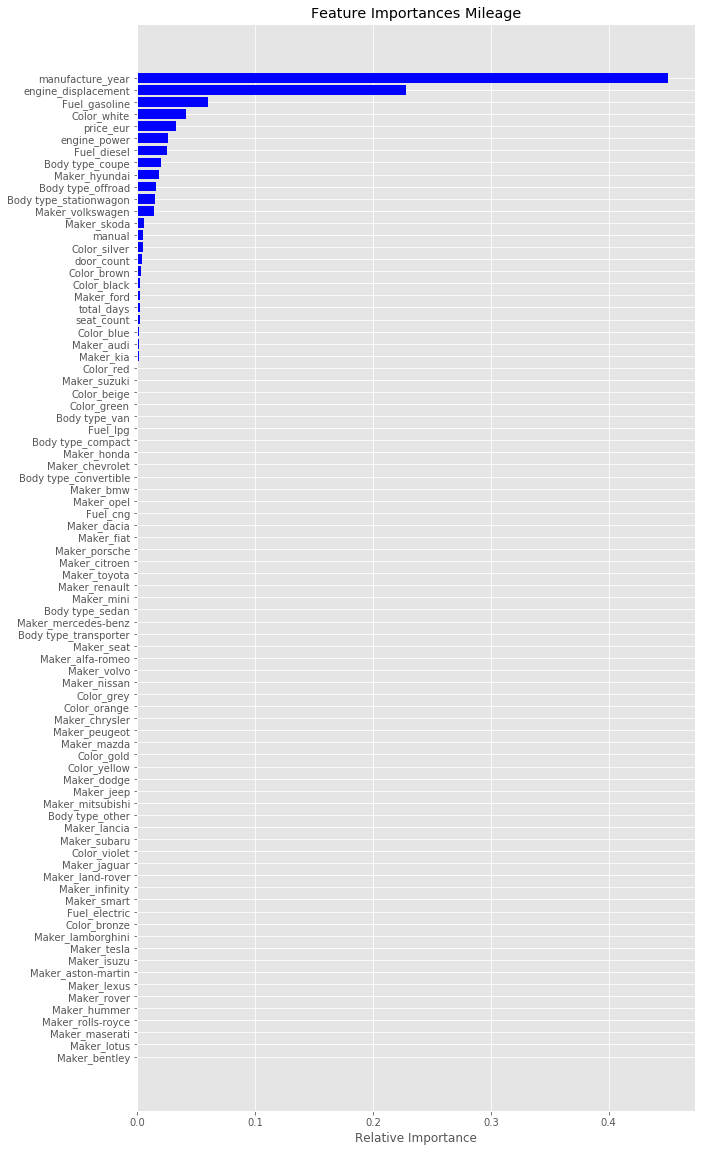

In [302]:
names = df.columns
importances = rf1clf.feature_importances_
indices = np.argsort(importances)


plt.figure(figsize=(10,20))
plt.title('Feature Importances Mileage')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), names[indices]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

We can see  the top 5 important features for the random forest for the prediction of mileage are:
- Manufacture year at 0.4506
- engine displacement at 0.2283
- fuel gasoline at 0.0601
- color white at 0.0415
- price eur at 0.0328

Manufacture year is because the longer a car in on the road the more miles it can accrue.  Engine displacement is most likely becuase cars with big engines are more likely to be collectors cars while cars with small engeines are through away cars.  Not sure about the fuel gasoline or  color white, they would need more researc hto determine why the  have a strong affect on random forest in predicting mileage.  The price eur is because newer cars are more expenxive and most or the time a car with alot of mileage are not worth much.

#### Body type random forest
For the task of predicting body type we had good results with random forest so what is important. Using feature importance we will see what is effecting the different results.  We will run the same steps for body type.

In [326]:
rf2clf = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=1)
rf2clf.fit(X2_train,y2_train) 
rf2_y_hat = rf2clf.predict(X2_test) # get test set precitions
names = df2.columns

print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf2clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.17899999999999999, 'door_count'), (0.16700000000000001, 'seat_count'), (0.1225, 'Fuel_gasoline'), (0.096299999999999997, 'engine_displacement'), (0.090399999999999994, 'engine_power'), (0.062199999999999998, 'Fuel_diesel'), (0.054699999999999999, 'price_eur'), (0.051200000000000002, 'Maker_skoda'), (0.046199999999999998, 'mileage'), (0.0206, 'manual'), (0.015299999999999999, 'Maker_citroen'), (0.011299999999999999, 'manufacture_year'), (0.0111, 'total_days'), (0.0091999999999999998, 'Maker_hyundai'), (0.0066, 'Maker_bmw'), (0.0054999999999999997, 'Maker_jeep'), (0.0051000000000000004, 'Maker_land-rover'), (0.0048999999999999998, 'Color_grey'), (0.0040000000000000001, 'Maker_opel'), (0.0040000000000000001, 'Maker_ford'), (0.0038999999999999998, 'Maker_mitsubishi'), (0.0035999999999999999, 'Maker_suzuki'), (0.0033999999999999998, 'Maker_seat'), (0.0028999999999999998, 'Color_red'), (0.0023999999999999998, 'Maker_nissan'), (0.0022000000000000001, 'Maker

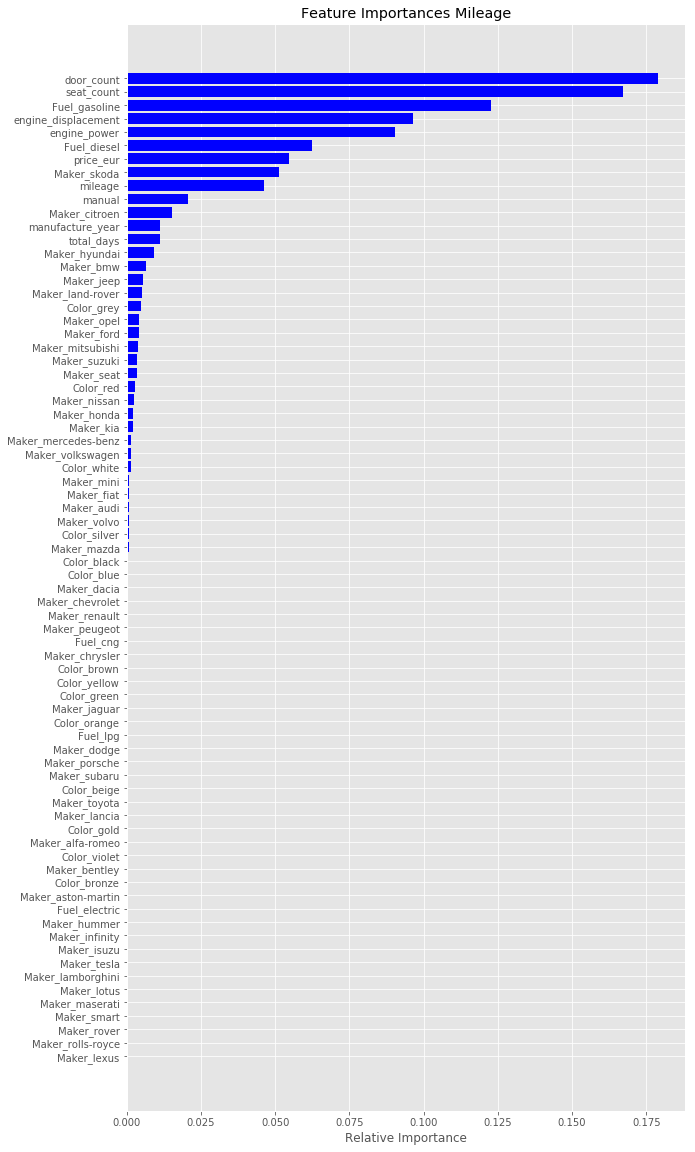

In [327]:
names2 = df2.columns
importances2 = rf2clf.feature_importances_
indices2 = np.argsort(importances2)


plt.figure(figsize=(10,20))
plt.title('Feature Importances Mileage')
plt.barh(range(len(indices2)), importances2[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), names2[indices2]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

Looking at the plot above you can see that for body type more variables where important to the random forest algorithm.  The first 5 are below.
- Door count at 0.1490
- Seat count at 0.1670
- fuel gasoline at 0.1225
- eingine displacement at 0.0963
- engine power at 0.0904

The door count and seat count influence on body type is most likely beacuse some car body styles are determined by the number of doors and seats.  Four doors and four seat is most likely a sedan, two doors and fours seats is a coupe, and so forth.  The fuel type might have to deal with most diesels are trucks, most elcetric are sedans, and more lpg are trucks in work force.  Engine power and displacement most like is related to mid power vehicles are more likely to be family cars.  High power cars are probalbly more likely to be trucks or coupes.

#### KNN

After an exhaustive search I have not been able to find a way to find the importance of features for KNN models.  So this section will have to be skipped.

#### Logistic regression - mileage

we are looking for the most imporatant variables for the logistic regression model.  We will be focusing on the absolute value of the normalized variables.  We will display them in a plot and then print out the variables with the threshold of a 0.2 variable coeffient.

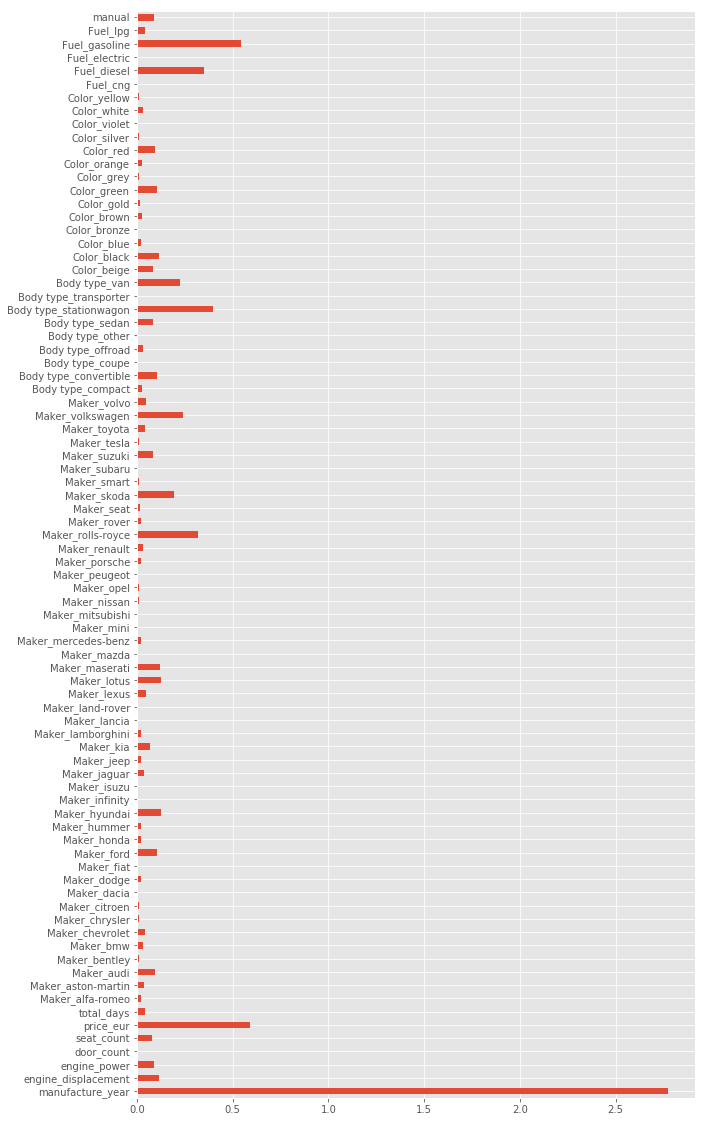

Body type_stationwagon has weight of 0.233207517989
Maker_rolls-royce has weight of 0.290971009146
Fuel_diesel has weight of 0.433502902707
Fuel_gasoline has weight of 0.451965266316
price_eur has weight of 0.577904697426
manufacture_year has weight of 2.73685689286


In [330]:
from sklearn.preprocessing import StandardScaler



# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) #

# train the model just as before
lrclf = LogisticRegression(penalty='l1') 
lrclf.fit(X_train_scaled,y_train) 

lr_y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(10,20))
weights = pd.Series(abs(lrclf.coef_[0]),index=df.columns)
weights.plot(kind='barh')
plt.show()

zip_vars = zip(abs(lr_clf.coef_.T),df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    if abs(coef) >.2:  
        print(name, 'has weight of', coef[0]) # now print them out

We printed the variables with the coeffeint of .2 or greater getting the most important normalized variables for the logistic regession model.  This gives the top 6 variables for predicting the mileage of a vehicle with logistic regression.   The influence of manufacture year on mileage is because the newer cars have less time to build up miles.  The price of the car goes down as the car gets older and is driven more.  Fuel gasoline and fuel diesel have a strong influence because most electric cars and lpg cars are newer and have not had as much time onf the road.  I am not sure why Rolls Royce and station wagons have such a strong influence, these would need more analysis to determine the reason.

#### Adaboost - body type feature importance

Adaboost will display feature importance the same way we did with random forest, using the feature importance parameter.

In [331]:
clf = AdaBoostClassifier(n_estimators= 50,learning_rate = 1.5, random_state=True)
clf.fit(X2_train,y2_train) 
ad_y2_hat = clf.predict(X2_test)
names = df2.columns

print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.38, 'price_eur'), (0.16, 'engine_displacement'), (0.080000000000000002, 'door_count'), (0.059999999999999998, 'total_days'), (0.059999999999999998, 'Maker_fiat'), (0.040000000000000001, 'seat_count'), (0.040000000000000001, 'engine_power'), (0.040000000000000001, 'Maker_skoda'), (0.040000000000000001, 'Maker_hyundai'), (0.040000000000000001, 'Maker_bmw'), (0.02, 'mileage'), (0.02, 'Maker_mercedes-benz'), (0.02, 'Color_white'), (0.0, 'manufacture_year'), (0.0, 'manual'), (0.0, 'Maker_volvo'), (0.0, 'Maker_volkswagen'), (0.0, 'Maker_toyota'), (0.0, 'Maker_tesla'), (0.0, 'Maker_suzuki'), (0.0, 'Maker_subaru'), (0.0, 'Maker_smart'), (0.0, 'Maker_seat'), (0.0, 'Maker_rover'), (0.0, 'Maker_rolls-royce'), (0.0, 'Maker_renault'), (0.0, 'Maker_porsche'), (0.0, 'Maker_peugeot'), (0.0, 'Maker_opel'), (0.0, 'Maker_nissan'), (0.0, 'Maker_mitsubishi'), (0.0, 'Maker_mini'), (0.0, 'Maker_mazda'), (0.0, 'Maker_maserati'), (0.0, 'Maker_lotus'), (0.0, 'Maker_lexus'), (

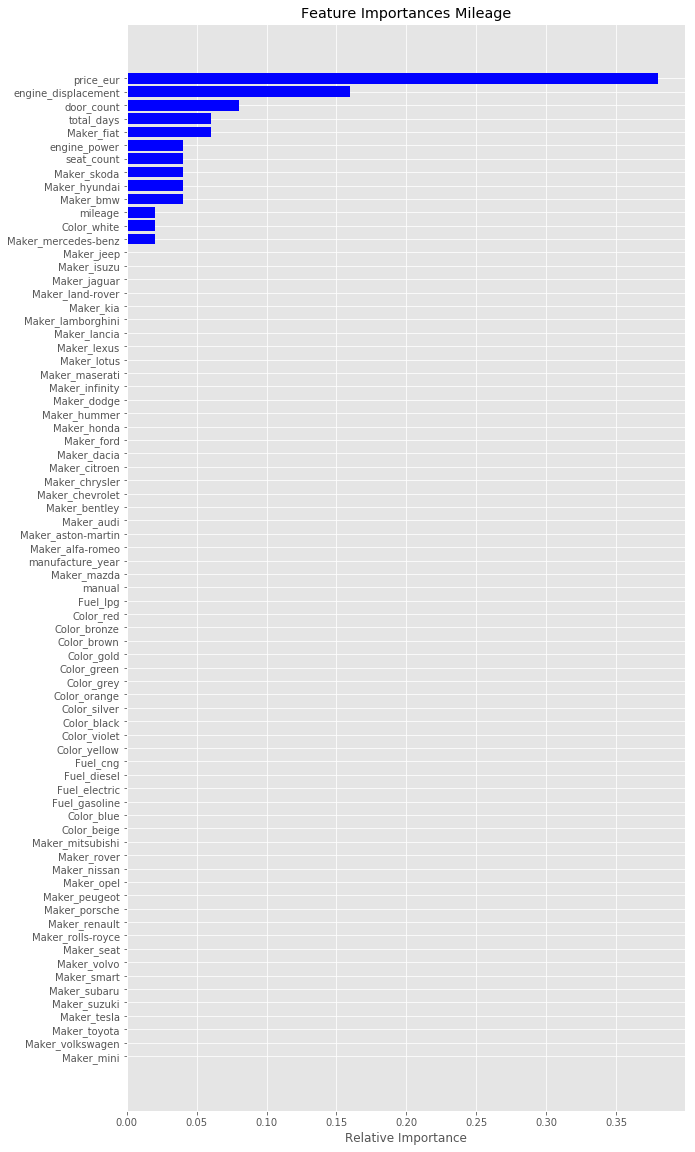

In [332]:
names2 = df2.columns
importances2 = clf.feature_importances_
indices2 = np.argsort(importances2)


plt.figure(figsize=(10,20))
plt.title('Feature Importances Mileage')
plt.barh(range(len(indices2)), importances2[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), names2[indices2]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

First thing you notice when looking at the feature importance for Adaboost when predicting body type is how many variabes have zero effect onthe modeling. Out of 74 varibles only 13 have any effect on the model.  This is mouch more importance given to these variables than Random forest. 

Th top 5 are
- Price Eur at 0.38
- Engine idsplacement at 0.16
- door count at 0.08
- total day at 0.06
- maker Fiat at 0.06

I can understand price eur having an influence on body style, the more exotic body styles, converibles and coupes, cost more.  Engine displacement might have an effect because of larger engines are in certian body styles, but I ma not sure.  It is suprising that door count is so low here beacuse certian body styles are defined by their door count.  I can see total days having a influence on predicting body style because more desired body styles do not stay on the market as long as some of the less desirable body styles.  I have no clue why Fiat is in the top five for influencing body style.

## Deployment

While our model did not produce any groundbreaking results to the auto industry, we were able to shed light on some of the more important features car manufactures should consider when designing and selling their automobiles. In task 1 we showed that price was an important attribute when predicting if cars had over 100k, indicating that the cheaper the car the more likely it was to have over 100k miles. This could mean that the cheaper cars being purchase are being used as commuter cars and the more expensive cars are being preserved better due to their price tag. An automobile company could use this information to put greater emphasis on long lasting cars that come with cheaper price tags.

In order to measure the value of our model, we could track the areas the companies make changes in and try to quantify if we see an improvement in those areas. For example, if a company were to use our model to impact sales, we could see if there was a statistically significant increase in sales after our model was put into use. If there is improvement then our model was beneficial to the company. One such area our model could impact is which body design should an automotive company manufacture more.

Our model would have benefited from some additional attributes however such as sales for each model type. As cars are meant to be sold, it would have been good to know if certain models sold better than others and then modeled to see what attributes are the best predictor of sales. It would have also been interesting to know if the cars came with advanced safety features or GPS navigation so we could understand the impact those have on sales.

Finally, our model would not need to be updated as frequently as changes to automobiles happens yearly when new models are released or old models are changed. Therefore, our model would need to be rerun once a year to keep in touch with the latest changes to the automobile industry.

## Exceptional Work - Variable reduction using Variance Threshold.

For our exceptional work we will use variance threshold to reduce the number of variables and run it through a model on each dataset.  We will slowly increase the varaiance threshold dropping more and more varaible until we hit 50% variance.  We will use random forest model on both datasets since they have a strong result for both datasets.  The random froest will use 30% in 5% increments estimators and no max depth.


In [209]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

In [211]:
dfnew = df
dfnew2 = df2

In [212]:
X=dfnew.values
X2 = dfnew2.values

In [213]:

#*************************************Task 2 Random Forest
clf = RandomForestClassifier(n_estimators=50,max_depth=5, random_state=1)
acc = cross_val_score(clf,X,y=y,cv=cv)
print ("Task 1 Random Forest 0% Variance Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
print('shape is ',dfnew.shape)
#************************************Task 2 Random forest
clf = RandomForestClassifier(n_estimators=100, random_state=1)
acc = cross_val_score(clf,X2,y=y2,cv=cv)
print ("Task 2 Random Forest 0% Variance Average accuracy = ", acc.mean()*100, "+-", acc.std()*10)
print('shape is ',dfnew2.shape)
for i in range(1,7):
    #*************************************Variance threshold 
    VT = (i*5)/100
    percent = VT *100
    selector = VarianceThreshold(VT)
    selector.fit_transform(dfnew)
    idx = selector.get_support()
    dfnew = dfnew.loc[:,idx]
    X = dfnew.values
    #************************************************      
    selector = VarianceThreshold(VT)
    selector.fit_transform(dfnew2)
    idx = selector.get_support()
    dfnew2 = dfnew2.loc[:,idx]
    X2 = dfnew2.values
    #*************************************Task 2 Random Forest
    clf = RandomForestClassifier(n_estimators=50,max_depth=5, random_state=1)
    acc = cross_val_score(clf,X,y=y,cv=cv)
    print ("Task 1 Random Forest ",percent,"% Variance Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
    print('shape is ',dfnew.shape)
    #************************************Task 2 Random forest
    clf = RandomForestClassifier(n_estimators=100, random_state=1)
    acc = cross_val_score(clf,X2,y=y2,cv=cv)
    print ("Task 2 Random Forest ",percent,"% Variance Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
    print('shape is ',dfnew2.shape)

Task 1 Random Forest 0% Variance Average accuracy =  82.8490119371 +- 4.62605735496
shape is  (81500, 58)
Task 2 Random Forest 0% Variance Average accuracy =  28.7100155625 +- 0.521253677912
shape is  (81500, 55)
Task 1 Random Forest  5.0 % Variance Average accuracy =  81.6038945223 +- 11.0840761902
shape is  (81500, 12)
Task 2 Random Forest  5.0 % Variance Average accuracy =  24.178860366 +- 5.16665967406
shape is  (81500, 12)
Task 1 Random Forest  10.0 % Variance Average accuracy =  80.4065151529 +- 14.8321106585
shape is  (81500, 11)
Task 2 Random Forest  10.0 % Variance Average accuracy =  23.1494089821 +- 5.41061846587
shape is  (81500, 11)
Task 1 Random Forest  15.0 % Variance Average accuracy =  81.2456497958 +- 11.7997681819
shape is  (81500, 10)
Task 2 Random Forest  15.0 % Variance Average accuracy =  22.5261227169 +- 5.46675751258
shape is  (81500, 10)
Task 1 Random Forest  20.0 % Variance Average accuracy =  81.7351702201 +- 10.258092614
shape is  (81500, 9)
Task 2 Random F

As can be seen above.  When we increase the limit of the threshold of the variance to the columns to drop we loss some of our accuracy.  Our first jump dropped the most features from the datset but we only lost 1% of hte accuracy in the fist task and 4% in the second task.

For task 1(mileage) we had a jump in accuracy when we dropped the variance to 20% which had only 10 features in that model. That would be the threshold I would pick for running the predictive model as it would still have a strong accuracy, 1% off from the full feature set, and would be less likely for overfitting.

For task 2 (body type) there is a steady decline in accuracy until you  hit 20% variance threshold.  At this point it seems that the data has hit a stable core of features.  I  would pick to run the full model for this predictive model.  Even though it is only a drop of 4% in accuracy for the first step, when the original model has only 28% every percentage point is important.